In [1]:
import sys
from fastai.text import *
import html
import json
from fastText import load_model
import pandas as pd

In [2]:
path = '/Users/danielsafai/DATAMAGA/projects/nlp/ulmfit_v2/'

In [3]:
df = pd.read_pickle('/Users/danielsafai/DATAMAGA/projects/nlp/data/sentiment_data.pkl.gz')
df = df[['reviewBody','ratingValue']].rename(columns={'reviewBody':'text', 'ratingValue':'label'})

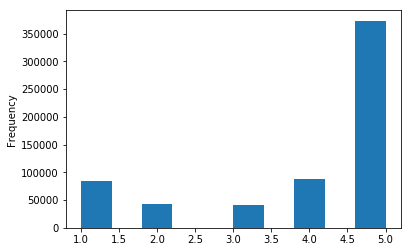

In [4]:
df['label'].plot('hist')

In [5]:
labels = df['label'].reset_index(drop=True)
texts = df['text'].reset_index(drop=True)

## Create train and validation data

In [6]:
np.random.seed(42)
trn_idx = np.random.permutation(len(texts))
texts = texts[trn_idx]
labels = labels[trn_idx]

In [7]:
train_limit = int(len(texts)*0.9)

In [8]:
col_names = ['label', 'text']
df_trn = pd.DataFrame({'text':texts[:train_limit], 'label':labels[:train_limit]}, columns=col_names)
df_val = pd.DataFrame({'text':texts[train_limit:], 'label':labels[train_limit:]}, columns=col_names)

In [9]:
df_trn.head(15)

,label,text
120691,5,Tak for hurtigt levering
141785,5,Det fungerede godt med forsendelsen
600816,5,Nemt og god service
600660,5,Ved denne forsendelse var informationen god og...
528854,5,ingen problemer når man henvender sig ang. ska...
281006,5,Alt er forløbet som forventet.
506755,4,Købte en nintendo dsi i pink til min datter og...
96273,1,Jeg har nu 3 gange fået en besked om at posten...
355520,5,Jeg er glad men produkter og levering . Jeg vi...
455180,5,Totalt nemt og hurtigt


In [10]:
df_trn.to_csv(path+'train.csv', header=False, index=False)
df_val.to_csv(path+'validation.csv', header=False, index=False)

### Tokenize and clean texts

In [11]:
tok_trn = Tokenizer(lang='da').process_all(df_trn['text'])

In [12]:
tok_val = Tokenizer(lang='da').process_all(df_val['text'])

In [13]:
tok_trn = [['xxbos']+sentence+['xxeos'] for sentence in tok_trn]
tok_val = [['xxbos']+sentence+['xxeos'] for sentence in tok_val]

In [14]:
tok_trn[:5]

[['xxbos', 'xxmaj', 'tak', 'for', 'hurtigt', 'levering', 'xxeos'],
 ['xxbos',
  'xxmaj',
  'det',
  'fungerede',
  'godt',
  'med',
  'forsendelsen',
  'xxeos'],
 ['xxbos', 'xxmaj', 'nemt', 'og', 'god', 'service', 'xxeos'],
 ['xxbos',
  'xxmaj',
  'ved',
  'denne',
  'forsendelse',
  'var',
  'informationen',
  'god',
  'og',
  'leveringen',
  'hurtig',
  '.',
  'xxeos'],
 ['xxbos',
  'ingen',
  'problemer',
  'når',
  'man',
  'henvender',
  'sig',
  'ang.',
  'skader',
  'og',
  'lignende',
  'god',
  'og',
  'venlig',
  'behandling',
  'xxeos']]

In [15]:
np.save(path+'lang_model/lbl_trn.npy', list(df_trn['label']))
np.save(path+'lang_model/lbl_val.npy', list(df_val['label']))
np.save(path+'lang_model/tok_trn.npy', tok_trn)
np.save(path+'lang_model/tok_val.npy', tok_val)

### Create dictionaries

In [16]:
tok_trn = np.load(path+'lang_model/tok_trn.npy', allow_pickle=True)
tok_val = np.load(path+'lang_model/tok_val.npy', allow_pickle=True)

In [17]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('xxmaj', 1524036),
 ('.', 879951),
 (',', 712036),
 ('xxbos', 565433),
 ('xxeos', 565433),
 ('og', 551523),
 ('jeg', 530974),
 ('at', 514003),
 ('det', 386202),
 ('i', 356810),
 ('er', 356440),
 ('en', 309872),
 ('til', 303063),
 ('ikke', 284566),
 ('på', 275417),
 ('har', 222596),
 ('den', 216514),
 ('var', 196664),
 ('med', 196406),
 ('for', 189087)]

In [18]:
max_vocab = 60000
min_freq = 2

In [19]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [20]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

51890

In [21]:
# Numericalize tokens by their id
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [22]:
np.save(path+'lang_model/trn_ids.npy', trn_lm)
np.save(path+'lang_model/val_ids.npy', val_lm)
pickle.dump(itos, open(path+'lang_model/itos.pkl', 'wb'))

### Create embedding matrix

In [23]:
# Set parameters
vs = len(itos)
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 300,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [24]:
f = load_model('/Users/danielsafai/DATAMAGA/projects/nlp/data/embedding data/cc.da.300.bin')

In [25]:
embedding_matrix = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    embedding_matrix[i] = np.array(list(f.get_word_vector(w)))#+list(np.zeros(100))) # ARGH!!!

In [26]:
# Torchify embedding matrix
embed = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
embed = embed.weight.data.copy_(torch.from_numpy(embedding_matrix))

### Prepare model

In [27]:
data_lm = TextLMDataBunch.from_ids(path=path+"lang_model", vocab=Vocab(itos), 
                                   train_ids=trn_lm, valid_ids=val_lm)

In [28]:
config = awd_lstm_lm_config.copy()
config['emb_sz'] = em_sz
config['n_hid'] = nh
config['n_layers'] = nl

In [43]:
_model_meta = {AWD_LSTM: {'hid_name':'emb_sz', 'url':URLs.WT103_FWD, 'url_bwd':URLs.WT103_BWD,
                          'config_lm':awd_lstm_lm_config, 'split_lm': awd_lstm_lm_split,
                          'config_clas':awd_lstm_clas_config, 'split_clas': awd_lstm_clas_split},
               Transformer: {'hid_name':'d_model', 'url':URLs.OPENAI_TRANSFORMER,
                             'config_lm':tfmer_lm_config, 'split_lm': tfmer_lm_split,
                             'config_clas':tfmer_clas_config, 'split_clas': tfmer_clas_split},
               TransformerXL: {'hid_name':'d_model',
                              'config_lm':tfmerXL_lm_config, 'split_lm': tfmerXL_lm_split,
                              'config_clas':tfmerXL_clas_config, 'split_clas': tfmerXL_clas_split}}
_model_meta[AWD_LSTM]["config_lm"]["emb_sz"] = 300

In [47]:
def get_language_model(arch:Callable, vocab_sz:int, config:dict=None, drop_mult:float=1.):
    "Create a language model from `arch` and its `config`, maybe `pretrained`."
    meta = _model_meta[AWD_LSTM]
    #print(meta['config_lm'])
    config = ifnone(config, meta['config_lm']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    tie_weights,output_p,out_bias = map(config.pop, ['tie_weights', 'output_p', 'out_bias'])
    init = config.pop('init') if 'init' in config else None
    encoder = arch(vocab_sz, **config)
    enc = encoder.encoder if tie_weights else None
    decoder = LinearDecoder(vocab_sz, config[meta['hid_name']], output_p, tie_encoder=enc, bias=out_bias)
    model = SequentialRNN(encoder, decoder)
    return model if init is None else model.apply(init)

In [48]:
def language_model_learner(data:DataBunch, arch, config:dict=None, drop_mult:float=1., pretrained:bool=True,
                           pretrained_fnames:OptStrTuple=None, **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    model = get_language_model(arch, len(data.vocab.itos), config=config, drop_mult=drop_mult)
    meta = _model_meta[arch]
    learn = LanguageLearner(data, model, split_func=meta['split_lm'], **learn_kwargs)
    url = 'url_bwd' if data.backwards else 'url'
    if pretrained or pretrained_fnames:
        if pretrained_fnames is not None:
            fnames = [learn.path/learn.model_dir/f'{fn}.{ext}' for fn,ext in zip(pretrained_fnames, ['pth', 'pkl'])]
        else:
            if url not in meta:
                warn("There are no pretrained weights for that architecture yet!")
                return learn
            model_path = untar_data(meta[url] , data=False)
            fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn.load_pretrained(*fnames)
        learn.freeze()
    return learn

In [58]:
learner = language_model_learner(data_lm, AWD_LSTM, pretrained=False)

In [60]:
# Save encoder to re-write weights with custom embedding matrix
learner.save_encoder(path+'lang_model/eng_enc2')

In [61]:
# Load and overwrite weights
wgts = torch.load(path+'lang_model/eng_enc2.pth')
wgts['encoder.weight'] = embed
wgts['encoder_dp.emb.weight'] = embed

In [63]:
torch.save(wgts,path+'lang_model/dk_enc2.pth')

In [65]:
# Update learner with new encoder
learner.load_encoder(path+'lang_model/dk_enc2')

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
# Save encoder to re-write weights with custom embedding matrix
learn.save_encoder(path+'lang_model/eng_enc')

In [52]:
# Load and overwrite weights
wgts = torch.load(path+'lang_model/eng_enc.pth')
wgts['encoder.weight'] = embed
wgts['encoder_dp.emb.weight'] = embed

In [53]:
torch.save(wgts,path+'lang_model/dk_enc.pth')

In [54]:
# Update learner with new encoder
learn.load_encoder(path+'lang_model/dk_enc')

NameError: name 'learn' is not defined

### Model estimation

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(1, 2.51E-01, moms=(0.8,0.7))

In [ ]:
learn.save(path+'lang_model/fit_head')

In [ ]:
learn.load(path+'lang_model/fit_head');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save(path+'lang_model/fine_tuned')

In [ ]:
learn.load(path+'lang_model/fine_tuned');

In [ ]:
learn.save_encoder(path+'lang_model/fine_tuned_enc')

### Test

In [ ]:
TEXT = "Tak for rigtig god service."
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

### Classification

In [ ]:
import gc
gc.enable()

In [ ]:
gc.collect()

In [ ]:
# Load data
itos = pickle.load(open(path+'lang_model/itos.pkl', 'rb'))
trn_lm = np.load(path+'lang_model/trn_ids.npy', allow_pickle=True)
val_lm = np.load(path+'lang_model/val_ids.npy', allow_pickle=True)

In [ ]:
df_trn = pd.read_csv(path+'train.csv', header=None, names=col_names)
df_val = pd.read_csv(path+'validation.csv', header=None, names=col_names)

In [ ]:
data_clas = TextDataBunch.from_ids(path=path+"lang_model", vocab=Vocab(itos), 
                                   train_ids=trn_lm, valid_ids=val_lm, 
                                   train_lbls=, valid_lbls=)

In [ ]:
df_trn['text']

In [ ]:
def f_ids_to_sentence(ids, itos):
    tmp = {i:w for i,w in enumerate(itos)}
    print(' '.join([tmp[i] for i in ids]))
f_ids_to_sentence(trn_lm[0], itos)